# Chapter 03 - Classification

## MNIST

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

<Figure size 640x480 with 1 Axes>

This looks like a 5.

In [5]:
y[0]

'5'

As most ML algorithms expect numbers, let's cast the whole labels vector to integer:

In [6]:
import numpy as np

y = y.astype(np.uint8)

Before inspecting and looking for relationships in the data, we must set aside the test set. Lucky for us, the MNIST dataset already comes with a training data. The last 10,000 images out of the 70,000 are our test data

In [7]:
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar (you don’t want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen.

## Training a binary classifier

To simplify our problem, first let's make a classifier only for the number 5. A "5-detector" is an example of binary classifier.

In [8]:
y_train_5 = (y_train == 5) # True for all 5s, False otherwise
y_test_5 = (y_test == 5)

Let's build our classifier using a Stochastic Gradient Descent (SGD) classifier.

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

The SGDClassifier relies on randomness during training (hence the name “stochastic”). If
you want reproducible results, you should set the random_state parameter.

In [10]:
sgd_clf.predict([some_digit])

array([ True])

This looks good because we already knew that our test sample was a number 5.

## Performance Measures

### Measuring accuracy using cross-validation

Occasionally, we'll need more control over our cross-validation process than what Scikit-Learn provides off the shelf. The following code does roughly the same thing as Scikit-Learn's *cross_val_score()* function.

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/home/alexandre/anaconda3/envs/eda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


The *StratifiedKFold* class performs stratified sampling to produce folds that contain a representative ratio of each class. 

At each iteration of the loop, we have different folds for training and a different fold for testing (just like cross validation) and each fold is constructed under the stratified sampling strategy.

Besides, at each iteration we train a different SGD model.

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Note that the values of our implementation of cross-validation matched exact the same values as the Scikit-Learn function *cross_val_score()*.

Our classifier got an accuracy of more than 95%, this looks amazing. Well, before you get too excited, let’s look
at a very dumb classifier that just classifies every single image in the “not-5” class:

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Our result still looks great, but this is not what we want to do. This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with *skewed datasets* (i.e., when some classes are much more frequent than others).

## Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the
*confusion matrix*. The general idea is to count the number of times instances of
class A are classified as class B. For example, to know the number of times the
classifier confused images of 5s with 3s, you would look in the fifth row and
third column of the confusion matrix.

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

| | Prediction 0 | Prediction 1 |
| --- | --- | --- |
| class 0 | True Negative | False Positive |
| class 1 | False Negative | True Positive |

A perfect classifier would
have only true positives and true negatives, so its confusion matrix would have
nonzero values only on its main diagonal.

In [16]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

A confusion matrix provide a lot of information and you may think it is too much. Another concise metrics is the accuracy of the positive predictions; this is called the precision of the classifier.

**Precision: Accuracy of the positive predictions**

$$ precision = \frac{TP}{TP + FP} $$

(Note: true positive divided by the sum of column 2.)

A trivial way to have perfect precision is to make one single positive prediction and ensure it is correct (precision = 1/1 = 100%). But this would not be very useful, since the classifier would ignore all but one positive instance.

So precision is typically used along with another metric named recall, also called *sensitivity* or the *true positive rate (TPR)*: this is the ratio of positive instances that are correctly detected by the classifier.

**Recall: True Positive Rate**

$$ recall = \frac{TP}{TP + FN} $$

(Note: true positive divided by the sum of row 2.)

## Precision and Recall

Of course, we can calculate the Precision and Recall of a classifier using Scikit-Learn.

In [17]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) 

0.8370879772350012

In [18]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

Now our classifier does not look as good as it did earlier. From our results, we know that when it claims an image represents a 5, it is correct only 83.7% of the time. Moreover, when an image is indeed a 5, is only detects it 65.1% of the time.

It is often convenient to combine precision and recall into a single metric called
the  $F_1$ score, in particular if you need a simple way to compare two classifiers.
The $F_1$ score is the harmonic mean of precision and recall.
Whereas the regular mean treats all values equally, the harmonic mean gives
much more weight to low values. As a result, the classifier will only get a high
$F_1$ score if both recall and precision are high.

**$F_1$ score**

$$ F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}} $$

In [19]:
from sklearn.metrics import f1_score

f1_score(y_train_5,  y_train_pred)

0.7325171197343846

The $F_1$ score favors classifiers that have similar precision and recall.

## Precision/Recall Trade-off

Unfortunately, increasing precision reduces recall, and vice versa. This is called the *precision/recall trade-off*.

Our SGD Classifier is a function that output a positive prediction when its output is greater than a certain threshold. The following image highlights what is the relationship between precision and recall when we increase or decrease the threshold.

![precision_recall_tradeoff](images/ch03_precision_recall_tradeoff.png)

Figure 3-3 was taken directly from the book.

Scikit-Learn does not let you set the threshold directly, but it does give you
access to the decision scores that it uses to make predictions. Instead of calling
the classifier’s *predict()* method, you can call its *decision_function()*
method, which returns a score for each instance, and then use any threshold you
want to make predictions based on those scores:

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [21]:
threshold = 0 # The SGD Classifier uses a threshold equal to 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [22]:
# raising the threshold
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

### How to decide the threshold to use?

First, use the *cross_val_predict()* function to get the scores of all instances in the training
set, but this time specify that you want to return decision scores instead of predictions:

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [24]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

With these scores, use the *precision_recall_curve()* function to compute precision and recall for all possible thresholds:

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Finally, use Matplotlib to plot precision and recall as functions of the threshold
value

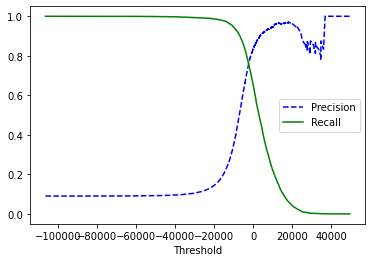

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()
    plt.xlabel('Threshold')
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Another way to select a good precision/recall trade-off is to plot the precision directly against the recall:

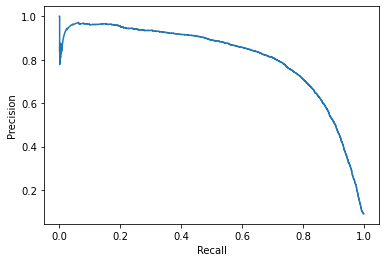

In [27]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
plot_precision_vs_recall(precisions, recalls)
plt.show()

To understand how you could use these plots. Suppose you decide to aim for 90% precision. Then, from plot 1, you know you need to set up a threshold of about 4000. To be more precise you can search for the lowest threshold that gives you 90% precision (*np.argmax()* will give you the first index of the maximum value, which in this case means the first *True* value):

In [28]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
threshold_90_precision

3370.0194991439557

To make predictions (on the training set now), instead of calling the classifier's *predict()* method, you can run this code:

In [29]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [30]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [31]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

Great, you have a 90% precision classifier! As you can see, it is fairly easy to create a classifier with virtually any precision you want: just set a high enough threshold, and you’re done. Great, you have a 90% precision classifier! As you can see, it is fairly easy to create a classifier with virtually any precision you want: just set a high enough threshold, and you’re done. 

## The ROC Curve

The **receiver operating characteristic** (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the **true positive rate** (recall) against the **false positive rate** (FPR). 

This is equivalent to plot the true positives divided by the sum of row 2 (actual class 1) against the false positives divided by the sum of row 1 (actual class 0).

Note that the FPR is equal

$$FPR = 1 - TNR$$

where TNR stands for **true negative rate**. The TNR is also called **specificity**. Hence, the ROC curve plots **sensitivity** (recall) versus 1 - **specificity**.

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

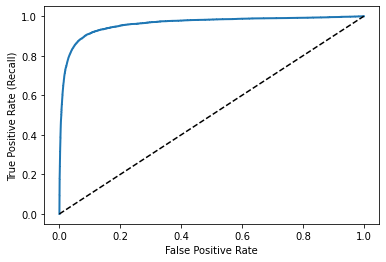

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    
plot_roc_curve(fpr, tpr)
plt.show()

Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. Again, look at the confusion matrix table, increasing FPR implies also increasing the number of predictions of 1's. In its turn, this will also increase the number of TPR (recall).

| | Prediction 0 | Prediction 1 |
| --- | --- | --- |
| class 0 | True Negative | False Positive |
| class 1 | False Negative | True Positive |

The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the **area under the curve (AUC)**. A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC:

In [34]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### When to decide between the Precision/Recall (PR) curve and the ROC curve

Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-left corner).

## Comparing Random Forest against SGD classifier

Let’s now train a *RandomForestClassifier* and compare its ROC curve and ROC AUC score to those of the *SGDClassifier*. First, you need to get scores for each instance in the training set. But due to the way it works (see Chapter 7), the *RandomForestClassifier* class does not have a *decision_function()* method. Instead, it has a *predict_proba()* method.

In [60]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [61]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

The *roc_curve()* function expects labels and scores, but instead of scores you can give it class probabilities. Let’s use the positive class’s probability as the score:

In [62]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

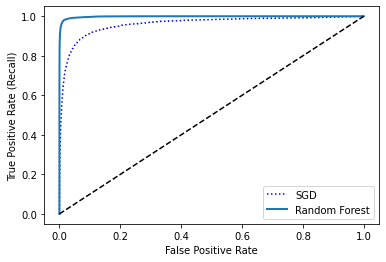

In [63]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

As you can see, the random forest classifier is much better than the SGD classifier. Let's evaluate its auc:

In [64]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [70]:
precision_sgd = precision_score(y_train_5, y_train_pred) 
precision_forest = precision_score(y_train_5, (y_scores_forest >= 0.5))

print('Precision SGD: ', precision_sgd)
print('Precision Random Forest: ', precision_forest)

Precision SGD:  0.8370879772350012
Precision Random Forest:  0.9897468089558485


In [71]:
recall_sgd = recall_score(y_train_5, y_train_pred) 
recall_forest = recall_score(y_train_5, (y_scores_forest >= 0.5))

print('Recall SGD: ', recall_sgd)
print('Recall Random Forest: ', recall_forest)

Recall SGD:  0.6511713705958311
Recall Random Forest:  0.8725327430363402


As you can see, the Random Forest Classifier increased by a lot our performance measures.

You now know how to train binary classifiers, choose the appropriate metric for your task, evaluate your classifiers using cross-validation, select the precision/recall trade-off that fits your needs, and use ROC curves and ROC AUC scores to compare various models. Now let’s try to detect more than just the 5s.

## Multiclass Classification

Multiclass classifiers as the name suggests are classifiers that can distinguish between more than one classes, as is the case for binary classifiers.

However, not all classifiers supports the multiclassification task. The SGD, Random Forest, and naive Bayes are capable of handling multiple classes natively. Others, such as Logistic Regressions and Support Vector Machines, are strictly binary classifiers.

Nonetheless, we can still use some strategies to perform multiclass classification with binary classifiers. There are two common, stratetegies: One versus the Rest (OvR) and One versus One (OvO).

- **OvR**: In the OvR strategy, to perform multiclassification we train a binary classifier for each class, just like we did for the 5-class binary classifier, we would train a binary classifier to detect 0's, 1's, and so on until reach the last class (9's).

- **OvO**: In the OvO strategy, we train a binary classifier for each pair of digits: one to distinguish 0's and 1's, 0's and 2's and so on. If there are N classes, you need to train $N \times (N - 1) / 2$ classifiers. In the case of the 10 digit classification, you need 45 classifiers. When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set. For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets. For most binary classification algorithms, however, OvR is preferred.

Scikit-learn detects when you are trying to perform multiclassification with a natively binary classifier, and automatically runs OvR or OvO, depending on the algorithm. Let's try this with a SVM.

In [73]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

This code trains the SVC on the training set using the original target classes from 0 to 9 (*y_train*), instead of the 5-versus-the-rest target classes (*y_train_5*). Then it makes a prediction (a correct one in this case). Under the hood, Scikit-Learn actually used the OvO strategy: **it trained 45 binary classifiers, got their decision scores for the image, and selected the class that won the most duels.**

If you call the decision_function() method, you will see that it returns 10 scores per instance (instead of just 1). That’s one score per class:

In [77]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [80]:
np.argmax(some_digit_scores)

5

In [81]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [83]:
svm_clf.classes_[5]

5

We can force Scikit Learn to use OvR or OvO with the classes *OneVsOneClassifier* or *OneVsRestClassifier*, respectively.

To use them, simply pass a classifier to it, don't need to be a strict binary one. Let's try out our SVC classifier using the OvR approach:

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

In [ ]:
len(ovr_clf.estimators_)

Besides, as said earlier, SGD supports multiclassification natively. Therefore, we don't need to use any strategy such as OvR and OvO to get the classifier running:

In [35]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

Differently from the SVM case, where the return value of the *decision_function* was 10 scores per instance (class). Now the *decision_function* just returns one value per class.

In [36]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

We can, as usual, evaluate this SGD classifier using cross-validation:

In [37]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

It gets over 84% on all test folds. If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still do much better. Simply scaling the inputs (as discussed in Chapter 2) increases accuracy above 89%:

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

## Error Analysis

Reallistically, you would explore data preparation options and try several models, tuning their hyperparameters with *GridSearchCV*. However, for the purpose of error analysis, let's suppose we already find our best model. To picture this scenario, we are going to use our SGD classifier, we just built.

In [39]:
y_train_pred = cross_val_predict(sgd_clf_clf_clf, X_train_scaled, y_train, cv=3)
coconfusion_matrix = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

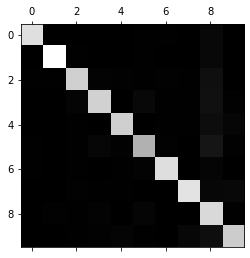

In [41]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

This image looks really good, since the diagonal entries are clearer than the others, except the case for the 5's. It seems that our classifier is still missing some 5's. In fact, we could improve even further this visualization considering not only the absolute numbers but the error rates. To accomplish that, divide each value in the matrix by the number of images in the corresponding class. This is also really useful for classes that have abundant instances in the dataset. 

In [42]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

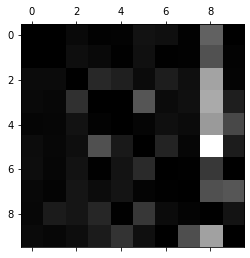

In [43]:
# Fill the diagonal with zeros to keep only the errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Now we can clearly see the types of errors the classifier makes. Remember that rows represent actual classes, while columns represent predicted classes. 

"The column for class 8 is quite bright, which tells you that many images get misclassified as 8s. However, the row for class 8 is not that bad, telling you that actual 8s in general get properly classified as 8s. As you can see, the confusion matrix is not necessarily symmetrical. You can also see that 3s and 5s often get confused (in both directions).

Analyzing the confusion matrix often gives you insights into ways to improve your classifier. Looking at this plot, it seems that your efforts should be spent on reducing the false 8s. For example, you could try to gather more training data for digits that look like 8s (but are not) so that the classifier can learn to distinguish them from real 8s. Or you could engineer new features that would help the classifier—for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none). Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns, such as closed loops, stand out more."

Analyzing individual errors can also be a good way to gain insights on what your classifier is doing and why it is failing, but it it more difficult and time-consuming. For example, let's plot examples of 3s and 5s:

In [44]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [47]:
# EXTRA (DIRECTLY FROM THE BOOK)
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

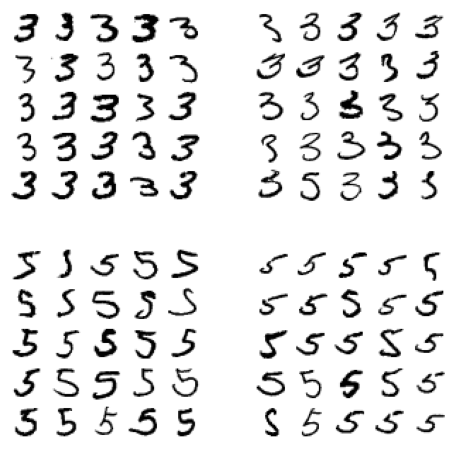

In [48]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

The two 5 × 5 blocks on the left show digits classified as 3s, and the two 5 × 5
blocks on the right show images classified as 5s.

However, most misclassified images seem like obvious errors to us, and it’s hard to understand why the classifier made the mistakes it did. The reason is that we used a simple SGDClassifier, which is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. So since 3s and 5s differ only by a few pixels, this model will easily confuse them.